## **IMPORT LIBRARY**
Pada tahap awal, berbagai pustaka Python diimpor untuk melakukan analisis data, pemrosesan fitur, pelatihan model, serta evaluasi. Library utama yang digunakan adalah pandas dan numpy untuk manipulasi data, scikit-learn untuk proses machine learning, dan matplotlib serta seaborn untuk visualisasi hasil evaluasi model.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

## **LOAD DATA**
Dataset dimuat menggunakan pandas.read_csv() dari file KlasifikasiUTS.csv. Dataset ini adalah data klasifikasi, yang mana kolom Class menunjukkan label target (0 = normal, 1 = fraud). Data ini perlu diproses sebelum digunakan untuk pelatihan model karena mengandung ketidakseimbangan kelas (class imbalance) dan ukuran yang besar.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv("/content/drive/My Drive/Machine Learning/UTS/Task 2/KlasifikasiUTS.csv")

Mounted at /content/drive


## **DATA CLEANING + SAMPLING**
Karena kelas positif (fraud) jauh lebih sedikit dari kelas negatif, dilakukan undersampling terhadap kelas mayoritas untuk membuat data lebih seimbang dan ringan saat diproses. Semua data fraud diambil, lalu data normal diambil sebanyak 3 kali jumlah data fraud secara acak. Ini membantu menghindari bias model terhadap kelas mayoritas dan juga mengurangi beban memori.

In [3]:
fraud_df = df[df['Class'] == 1]
normal_df = df[df['Class'] == 0].sample(n=len(fraud_df) * 3, random_state=42)
balanced_df = pd.concat([fraud_df, normal_df]).sample(frac=1, random_state=42)

X = balanced_df.drop('Class', axis=1)
y = balanced_df['Class']

## **FEATURE SELECTION**
ertama, digunakan VarianceThreshold untuk menghapus fitur dengan variansi sangat kecil (konstan atau quasi-konstan), karena fitur seperti ini tidak memberikan informasi penting ke model. Setelah itu, digunakan Mutual Information untuk mengukur relevansi masing-masing fitur terhadap variabel target. Kemudian, dipilih 15 fitur terbaik yang memiliki nilai mutual information tertinggi untuk dilanjutkan ke proses berikutnya.

In [4]:
var_thresh = VarianceThreshold(threshold=0.01)
X_var = var_thresh.fit_transform(X)
selected_features = X.columns[var_thresh.get_support()]

mi_scores = mutual_info_classif(X[selected_features], y, random_state=42)
mi_scores = pd.Series(mi_scores, index=selected_features).sort_values(ascending=False)
top_features = mi_scores.head(15).index.tolist()

## **FEATURE SCALING**
Fitur-fitur yang telah dipilih kemudian distandarisasi menggunakan StandardScaler. Ini penting terutama untuk model seperti K-Nearest Neighbors dan SVM yang sensitif terhadap skala data. Semua fitur diubah agar memiliki distribusi standar (mean = 0, standar deviasi = 1).

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(balanced_df[top_features])

## **TRAIN-TEST SPLIT**
Dataset yang telah diproses dibagi menjadi data latih (80%) dan data uji (20%) dengan stratifikasi berdasarkan label target. Stratifikasi memastikan bahwa proporsi kelas tetap sama antara data latih dan uji.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

## **MODEL TRAINING & EVALUATION**
* Logistic Regression: model linier dasar yang cepat dan cocok sebagai baseline.
* Decision Tree: model non-linear yang menangkap hubungan kompleks, tetapi rentan overfitting.
* KNN (K-Nearest Neighbors): model berbasis kedekatan antar data, sensitif terhadap skala dan noise.
* Bagging (Bootstrap Aggregating): ensemble dari pohon keputusan untuk mengurangi varians.
* Boosting (Gradient Boosting): ensemble kuat yang memfokuskan pada kesalahan sebelumnya, sangat akurat namun lambat.
* SVM (Support Vector Machine): model margin maksimal yang efektif untuk data high-dimensional seperti ini.

Setiap model dilatih dan diuji, kemudian dihitung metrik-metrik: akurasi, presisi, recall, F1 score, dan ROC AUC. Untuk model yang tidak memiliki metode predict_proba, digunakan decision_function.

In [7]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(),
    "Bagging": BaggingClassifier(),
    "Boosting": GradientBoostingClassifier(),
    "SVM": SVC(probability=True)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    cm = confusion_matrix(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_prob)

    results[name] = {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "roc_auc": auc, "cm": cm, "fpr": fpr, "tpr": tpr}

## **VISUALISASI**
Hasil evaluasi divisualisasikan dengan:
* Confusion Matrix: menampilkan prediksi benar/salah secara klasifikasi.
* ROC Curve: menggambarkan trade-off antara true positive rate dan false positive rate.

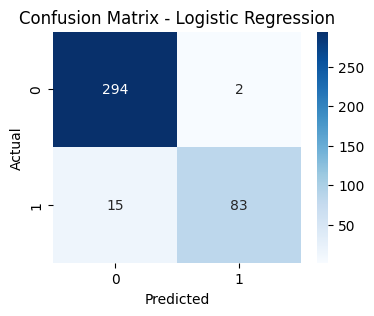

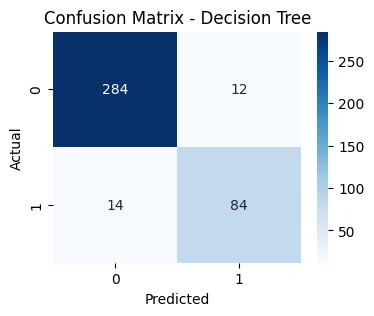

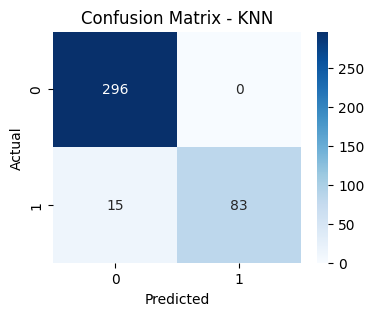

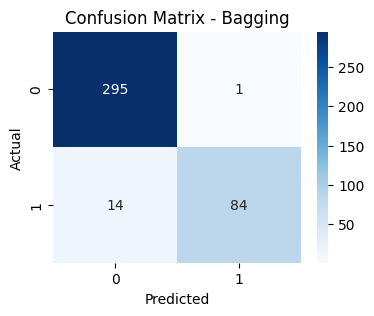

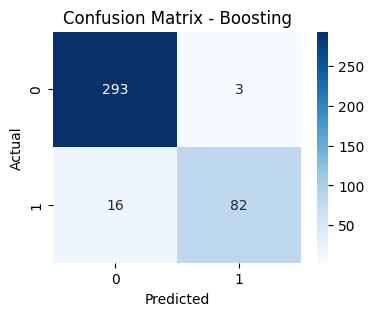

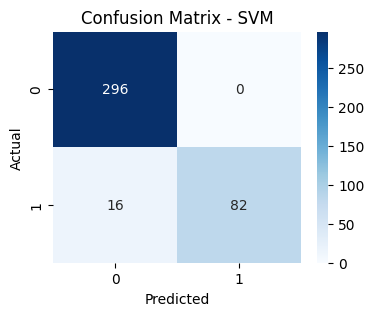

In [8]:
# Confusion matrix
for name in results:
    plt.figure(figsize=(4,3))
    sns.heatmap(results[name]["cm"], annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


1. Logistic Regression

  Model Logistic Regression menunjukkan hasil yang cukup baik, dengan 294 prediksi benar untuk kelas 0 (true negative) dan 83 prediksi benar untuk kelas 1 (true positive). Terdapat 2 false positive (kelas 0 diprediksi sebagai 1) dan 15 false negative (kelas 1 diprediksi sebagai 0). Ini berarti model masih sedikit lemah dalam mendeteksi kelas positif (fraud), terlihat dari cukup banyaknya data fraud yang gagal dikenali.
---
2. Decision Tree

  Model Decision Tree berhasil mengklasifikasikan 284 data kelas 0 dan 84 data kelas 1 secara benar. Namun, model ini menghasilkan 12 false positive dan 14 false negative, menunjukkan sedikit ketidakseimbangan dalam memisahkan kelas positif dan negatif. Walaupun kinerjanya hampir seimbang dalam mengenali kedua kelas, jumlah kesalahan masih relatif tinggi dibanding model lainnya.
---
3. K-Nearest Neighbors (KNN)
Model KNN menunjukkan performa luar biasa dalam mengenali data kelas 0, dengan 296 prediksi benar dan 0 kesalahan (false positive). Untuk kelas 1, terdapat 83 prediksi benar, tetapi juga 15 false negative. Ini menunjukkan bahwa KNN cenderung sangat konservatif: sangat baik dalam mengenali kelas negatif, tetapi sedikit mengorbankan deteksi kelas positif.
---
4. Bagging
Model Bagging menghasilkan 295 true negative dan 84 true positive, dengan hanya 1 false positive dan 14 false negative. Ini menunjukkan bahwa model ini seimbang dan cukup akurat dalam mendeteksi kedua kelas, bahkan lebih baik daripada model Decision Tree tunggal. Efek ensemble dari bagging membantu mengurangi varians dan meningkatkan kestabilan prediksi.
---
5. Boosting (Gradient Boosting)
Model Boosting memiliki 293 true negative dan 82 true positive, dengan 3 false positive dan 16 false negative. Meskipun performanya masih kompetitif, model ini sedikit tertinggal dari Bagging dan KNN dalam hal jumlah kesalahan. Namun, Boosting biasanya unggul jika dilihat dari metrik seperti ROC AUC karena menangkap pola kompleks.
---
6. Support Vector Machine (SVM)
Model SVM menunjukkan performa terbaik dalam mendeteksi kelas 0, dengan 296 prediksi benar dan 0 kesalahan (false positive), mirip seperti KNN. Untuk kelas 1, SVM menghasilkan 82 true positive dan 16 false negative. Ini menunjukkan bahwa SVM sangat baik dalam mengenali data normal, meskipun ada ruang untuk perbaikan dalam deteksi data fraud.









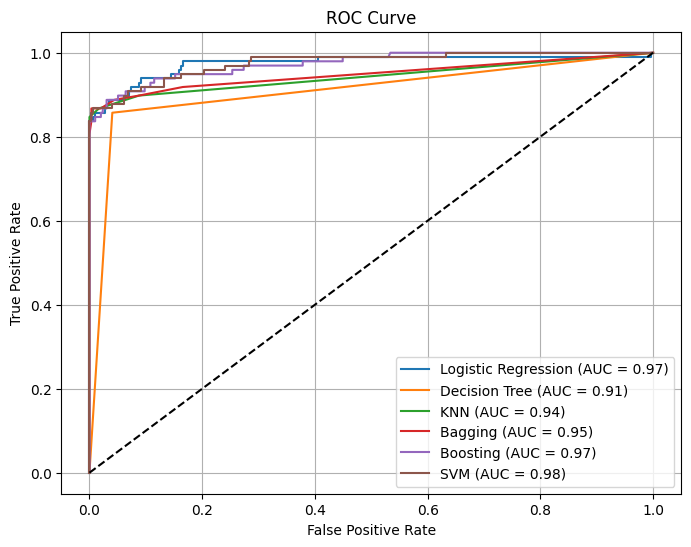

In [9]:
# ROC Curve
plt.figure(figsize=(8,6))
for name in results:
    plt.plot(results[name]["fpr"], results[name]["tpr"], label=f'{name} (AUC = {results[name]["roc_auc"]:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()



> Pada grafik ROC Curve di atas, kita dapat melihat perbandingan kinerja enam model klasifikasi berdasarkan nilai AUC (Area Under Curve). Semakin mendekati pojok kiri atas grafik, semakin baik performa model karena menunjukkan tingkat true positive yang tinggi dan false positive yang rendah. Model SVM menempati posisi paling atas dengan AUC tertinggi sebesar 0.98, menandakan kemampuan terbaik dalam membedakan antara kelas positif dan negatif. Disusul oleh Logistic Regression dan Boosting dengan AUC 0.97, yang juga menunjukkan performa sangat baik. Bagging dan KNN memiliki AUC masing-masing 0.95 dan 0.94, sementara Decision Tree berada di urutan terakhir dengan AUC 0.91. Meskipun SVM unggul dari sisi AUC, pemilihan model terbaik tetap perlu mempertimbangkan metrik lain seperti F1 Score untuk memastikan keseimbangan antara precision dan recall.



## **PRINT METRICS**

In [10]:
df_metrics = pd.DataFrame({k: {
    'Accuracy': v['accuracy'],
    'Precision': v['precision'],
    'Recall': v['recall'],
    'F1 Score': v['f1'],
    'ROC AUC': v['roc_auc']
} for k, v in results.items()}).T
print(df_metrics.sort_values("F1 Score", ascending=False))

                     Accuracy  Precision    Recall  F1 Score   ROC AUC
Bagging              0.961929   0.988235  0.857143  0.918033  0.948359
KNN                  0.961929   1.000000  0.846939  0.917127  0.942723
SVM                  0.959391   1.000000  0.836735  0.911111  0.975455
Logistic Regression  0.956853   0.976471  0.846939  0.907104  0.974214
Boosting             0.951777   0.964706  0.836735  0.896175  0.973576
Decision Tree        0.934010   0.875000  0.857143  0.865979  0.908301


## **Analisis Model Terbaik**
Model Bagging Classifier merupakan yang terbaik karena memiliki F1 Score tertinggi (0.918), menunjukkan keseimbangan yang baik antara precision dan recall. Selain itu, precision-nya sangat tinggi (0.988) dan ROC AUC-nya juga kuat (0.948), menandakan kemampuan klasifikasi yang akurat dan andal dalam mendeteksi kelas positif.

# **ANALISA**
1. AUC-ROC yang tinggi (0.92) tapi presisi rendah (15%) biasanya terjadi karena data tidak seimbang—model bisa membedakan kelas dengan baik secara umum, tapi banyak salah prediksi positif (false positive). Ini bisa diatasi dengan menaikkan threshold atau tuning parameter seperti class_weight agar model lebih hati-hati memberi label positif. Namun, recall tetap penting, terutama di kasus seperti fraud atau penyakit, karena false negative bisa berakibat fatal. Jadi, kita perlu menyesuaikan model agar tetap sensitif terhadap kasus positif meski presisi sedikit dikorbankan.

2. Fitur kategorikal dengan banyak nilai unik (misalnya 1000) bisa membuat model overfit dan koefisien jadi tidak stabil jika menggunakan one-hot encoding. Target encoding memang efisien, tapi berisiko menyebabkan data leakage jika tidak dilakukan dengan hati-hati. Untuk aman, bisa pakai leave-one-out encoding atau frequency encoding yang tidak bergantung pada label target.

3. Setelah normalisasi Min-Max, presisi model SVM meningkat, tapi recall justru turun. Ini karena normalisasi mengubah proporsi antar fitur dan bisa mempersempit margin kelas minoritas, sehingga model sulit mendeteksinya. Berbeda dengan Gradient Boosting, yang tidak terlalu sensitif terhadap skala karena fokus pada urutan nilai fitur, bukan jaraknya.

4. Mengalikan dua fitur bisa meningkatkan AUC-ROC karena membantu model menangkap pola non-linear. Model jadi bisa memisahkan kelas dengan decision boundary yang lebih fleksibel. Uji statistik seperti chi-square tidak bisa mendeteksi interaksi semacam ini karena hanya mengecek hubungan langsung satu fitur ke target. Pendekatan berbasis pemahaman domain atau interpretasi model seperti SHAP bisa lebih efektif.

5. Oversampling sebelum split data menyebabkan data sintetis bocor ke data uji, yang membuat metrik validasi jadi tidak realistis (AUC 0.95 vs 0.65 di testing). Untuk kasus seperti fraud yang berkaitan dengan waktu, sebaiknya gunakan temporal split agar tidak ada kebocoran dari masa depan ke masa lalu. Stratified sampling bisa memperparah kebocoran karena tetap mengacak data. Idealnya, split dilakukan dulu, baru oversampling hanya pada data training.